In [2]:
import os
import sys
AbsPath = str(os.path.abspath(""))+"/../.."
sys.path.append(AbsPath)
import importlib
import pickle
import numpy as np
import matplotlib as mpl
import colossus.halo.mass_adv as massdefs
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.ticker as tik
import scipy.integrate as integrate
from Functions import Functions as F
from Scripts.Plots import SDSS_Plots
Add_SDSS = SDSS_Plots.SDSS_Plots(11.5,15,0.1) #pass this halomass:min, max, and binwidth for amting the SDSS plots
from colossus.cosmology import cosmology
cosmology.setCosmology("planck15")
Cosmo =cosmology.getCurrent()
HMF_fun = F.Make_HMF_Interp() #N Mpc^-3 h^3 dex^-1, Args are (Mass, Redshift)
h = Cosmo.h
h_3 = h*h*h

/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/data/pg1g15/STEEL/Notebooks/Plots/../../Scripts/Plots/SDSS_Plots.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

FRACKSKY= 0.1404020420493216


In [1]:
importlib.reload(F)

NameError: name 'importlib' is not defined

In [3]:
#set plot paramaters here
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.titlepad'] = 20
plt.rcParams['font.size']=15
plt.rcParams['lines.linewidth']=2

In [7]:
#Abundance Matching Parameters
#Abundance Matching Parameters
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-2,\
'gamma11':0.08\
}


AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': False,\
'B18c':False,\
'B18t':False,\
'G18':False,\
'G18_notSE':False,\
'G19_SE':False,\
'G19_cMod':False,\
'Lorenzo18':False,\
'Moster': False,\
'Moster10': False,\
'Illustris': False,\
'z_Evo':True,\
'Scatter': 0.15,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT': False,\
'M_PFT1': False,\
'M_PFT2': False,\
'M_PFT3': False,\
'N_PFT1': False,\
'N_PFT2': False,\
'N_PFT3': False,\
'b_PFT1': False,\
'b_PFT2': False,\
'b_PFT3': False,\
'g_PFT1': False,\
'g_PFT2': False,\
'g_PFT3': False,\
'g_PFT4': False,\
'HMevo': False,\
'HMevo_param': None\
}

Paramaters = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
'SFR_Model': 'CE',\
'PreProcessing': False,\
'AltDynamicalTimeB': False\
}

Plot For abundance matching

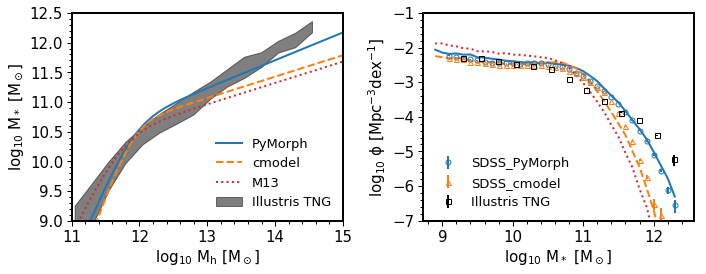

In [8]:
def Shank17AM(HM, ScatterOn = False):
    Mstar0 = 10.68
    Mhalo0 = 11.8
    alpha = 2.13
    beta = 1.68
    
    Part1 = np.power(10, alpha*(HM-Mhalo0))
    Part2 = np.power(1+np.power(10,beta*(HM-Mhalo0)), -1)
    if ScatterOn:
        Scatter = np.random.normal(scale = 0.15, size = np.shape(HM))
        return Mstar0 + np.log10(Part1*Part2) + Scatter
    else:
        return Mstar0 + np.log10(Part1*Part2)
def DM_to_SM_for_S17(SMF_X, HMF, Halo_MR, HMF_Bin, SMF_Bin, Paramaters, Redshift = 0, N = 5000):
    """
    Input
    SMF_X: Stellar Mass Function Mass Range log10[$M_\odot$]
    HMF: Halo Mass Function Weights log10[ $\Phi$ Mpc^{-3} h^3]
    Halo_MR: Halo Mass Function Mass Range log10[$M_\odot$ h^{-1}]
    HMF_Bin: Binwidth of Halo_MR
    SMF_Bin: Binwidth of SMF_X
    N: number of times to use
    """

    DM_In = np.repeat(Halo_MR - np.log10(h), N) #log Mh [Msun]
    Wt = np.repeat(np.divide(np.power(10, HMF + 3*np.log10(h))*HMF_Bin, N), N) #Phi/N [Mpc^-3]
    
    SM = Shank17AM(DM_In, ScatterOn = True) #log M* [Msun]
    
    #SM = np.log10(HM_SM.mean_stellar_mass(prim_haloprop = 10**(DM_In + np.log10(0.704)) )) - np.log10(0.704) + np.random.normal(scale = 0.1, size = np.shape(DM_In))
    
    SMF_Y, Bin_Edge = np.histogram(SM, bins = np.append(SMF_X, SMF_X[-1]+SMF_Bin), weights = Wt) #Phi [Mpc^-3], M* [Msun]
    
    return SMF_X, np.log10(np.divide(SMF_Y, SMF_Bin)) #M* [Msun], Phi [Mpc^-3]

X = np.arange(10, 15, 0.1) #M h-1 #virial
f, axarr = plt.subplots(1, 2, figsize=(10,4))

SMR_L = 9
SMR_U = 12.5
SMR_BW = 0.1
SMF_Bins, Y_t, Y_t_e, Y_sat, Y_sat_e, Y_cen, Y_cen_e =  Add_SDSS.SMF_Data()
#axarr[1].errorbar(np.divide(SMF_Bins[1:]+SMF_Bins[:-1], 2), Y_cen, yerr=Y_cen_e, fmt = "o", label = "SDSS_PyMorph", mfc = "None")
axarr[1].errorbar(SMF_Bins[1:], Y_cen[1:], yerr=Y_cen_e[:,1:], fmt = "o", label = "SDSS_PyMorph", mfc = "None")
#axarr[1].errorbar(SMF_Bins[:-1], Y_t, yerr=Y_t_e, label = "t_SE")

SMF_Bins, Y_t, Y_t_e, Y_sat, Y_sat_e, Y_cen, Y_cen_e =  Add_SDSS.SMF_Data(OverridePhoto = "MsMendCmodel")
axarr[1].errorbar(SMF_Bins[1:], Y_cen[1:], yerr=Y_cen_e[:,1:], fmt = "^", label = "SDSS_cmodel", mfc = "None")
#axarr[1].errorbar(SMF_Bins[:-1], Y_t, yerr=Y_t_e, label = "t_cMod")

#axarr[0].plot(X- np.log10(h), Shank17AM(np.log10(massdefs.changeMassDefinitionCModel(M=np.power(10, X), z=0.1, mdef_in='vir', mdef_out='200c')[0]) - np.log10(h)), "vC8",label = "S17", mfc = 'none')

"""
AbnMtch['Override_z'] = True
axarr[0].plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), ":C0", label = "override")

Override['beta10'] += 0.854
axarr[0].plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), "-C0", label = "G19")
Override['beta10'] -= 0.854
Override['beta10'] -= 0.73
axarr[0].plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), "-C0", label = "G19")
Override['beta10'] += 0.73

AbnMtch['Override_z'] = False
"""
AbnMtch['G19_SE'] = True
axarr[0].plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), "-C0", label = "PyMorph")
AbnMtch['G19_SE'] = False


AbnMtch['G19_cMod'] = True
axarr[0].plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), "--C1", label = "cmodel")
AbnMtch['G19_cMod'] = False
"""
AbnMtch['Behroozi18'] = True
AbnMtch['B18c'] = True
axarr[0].plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass_Alt(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), "-.C2",label = "B18")
AbnMtch['B18c'] = False
AbnMtch['Behroozi18'] = False
"""
AbnMtch['Moster'] = True
axarr[0].plot(X- np.log10(h), F.DarkMatterToStellarMass(np.log10(massdefs.changeMassDefinitionCModel(M=np.power(10, X), z=0.1, mdef_in='vir', mdef_out='200c')[0]) - np.log10(h), 0.1, Paramaters, ScatterOn = False), ":C3" ,label = "M13")
AbnMtch['Moster'] = False



#F.DM_to_SM(SMF_X, HMF, Halo_MR, HMF_Bin, SMF_Bin, Paramaters, Redshift = 0, N = 5000, UseAlt = False)
Redshift = 0.1
SM_bin = SMF_Bins[1] - SMF_Bins[0]
Halo_bin = 0.1
Halo_MR = np.arange(10, 16, Halo_bin)
Halo_MR_m200 = np.log10(massdefs.changeMassDefinitionCModel(M=np.power(10, Halo_MR), z=0.1, mdef_in='vir', mdef_out='200c')[0])
"""
AbnMtch['Override_z'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins, SMF, ":C0")

Override['beta10'] += 0.854
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins, SMF, "-C0")
Override['beta10'] -= 0.854
Override['beta10'] -= 0.73
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins, SMF, "-C0")
Override['beta10'] += 0.73

AbnMtch['Override_z'] = False
"""


AbnMtch['G19_SE'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins-SM_bin, SMF, "-C0")
AbnMtch['G19_SE'] = False
AbnMtch['G19_cMod'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins-SM_bin, SMF, "--C1")
AbnMtch['G19_cMod'] = False
"""
AbnMtch['Behroozi18'] = True
AbnMtch['B18c'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR_m200, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000, UseAlt = True)[1]
plt.plot(SMF_Bins, SMF, "-.C2")
AbnMtch['B18c'] = False
AbnMtch['Behroozi18'] = False
"""
AbnMtch['Moster'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR_m200, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins-SM_bin, SMF, ":C3")
AbnMtch['Moster'] = False


SMHM_ill = np.load(AbsPath+'/Data/Observational/Illustris/SMHM_fillbtwn_99.npy')
axarr[0].fill_between(SMHM_ill[0], SMHM_ill[1], SMHM_ill[2], color = 'k', alpha = 0.5, label = 'Illustris TNG')
SMF_ill = np.load(AbsPath+'/Data/Observational/Illustris/SMF_errbar_99.npy')
axarr[1].errorbar(SMF_ill[0], SMF_ill[1], yerr = [SMF_ill[2], SMF_ill[3]], color = 'k',  fmt = "s", label = 'Illustris TNG', mfc = None, fillstyle = "none")


#NM_SMHM = np.loadtxt(AbsPath+"/Data/Observational/Nicola_SAM/mstar-mhalos.dat").T
#axarr[0].plot(NM_SMHM[0], NM_SMHM[1], "k", label = "Menci14")

mpl.rcParams.update({'font.size': 13})
axarr[0].legend(loc = 4, frameon = False)
#axarr[1].legend(handles=lines_plotted, loc = 3, frameon = False)
axarr[1].legend(frameon = False)


axarr[0].set_ylim(9, 12.5)
axarr[0].set_xlim(11, 15)
axarr[1].set_ylim(-7, -1)
axarr[0].set_xlabel("$\mathrm{log_{10}}$ $\mathrm{M_h}$ $\mathrm{[M_\odot]}$")
axarr[0].set_ylabel("$\mathrm{log_{10}}$ $\mathrm{M_*}$ $\mathrm{[M_\odot]}$")
axarr[1].set_xlabel("$\mathrm{log_{10}}$ $\mathrm{M_*}$ $\mathrm{[M_\odot]}$")
axarr[1].set_ylabel("$\mathrm{log_{10}}$ $\mathrm{\phi}$ $\mathrm{[Mpc^{-3}dex^{-1}]}$")
                                                                            
plt.tight_layout()

plt.savefig(AbsPath+"/Figures/Paper2/AbundaceMtch_lowz.png")
plt.savefig(AbsPath+"/Figures/Paper2/AbundaceMtch_lowz.pdf")

plt.show()

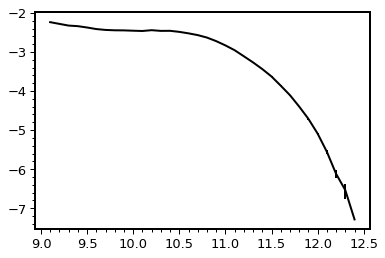

In [28]:
SMF_Bins, Y_t, Y_t_e, Y_sat, Y_sat_e, Y_cen, Y_cen_e =  Add_SDSS.SMF_Data()
plt.errorbar(SMF_Bins[1:], Y_cen[1:], yerr=Y_cen_e[:,1:], color = "k")
plt.show()

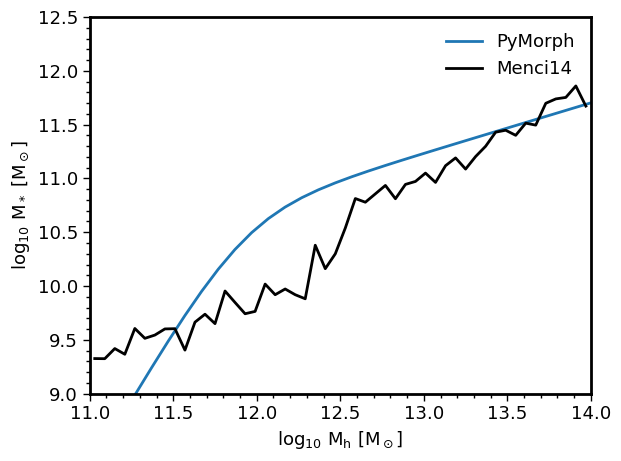

In [86]:
AbnMtch['G19_SE'] = True
plt.plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), "-C0", label = "PyMorph")
AbnMtch['G19_SE'] = False
NM_SMHM = np.loadtxt(AbsPath+"/Data/Observational/Nicola_SAM/mstar-mhalos.dat").T
plt.plot(NM_SMHM[0], NM_SMHM[1], "k", label = "Menci14")
plt.legend(frameon = False)
plt.ylim(9, 12.5)
plt.xlim(11, 14)
plt.xlabel("$\mathrm{log_{10}}$ $\mathrm{M_h}$ $\mathrm{[M_\odot]}$")
plt.ylabel("$\mathrm{log_{10}}$ $\mathrm{M_*}$ $\mathrm{[M_\odot]}$")
plt.tight_layout()

plt.savefig(AbsPath+"/Figures/Paper2/AbundaceMtch_Menci.png")
plt.savefig(AbsPath+"/Figures/Paper2/AbundaceMtch_Menci.pdf")
plt.show()

Plots for cartoons

/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


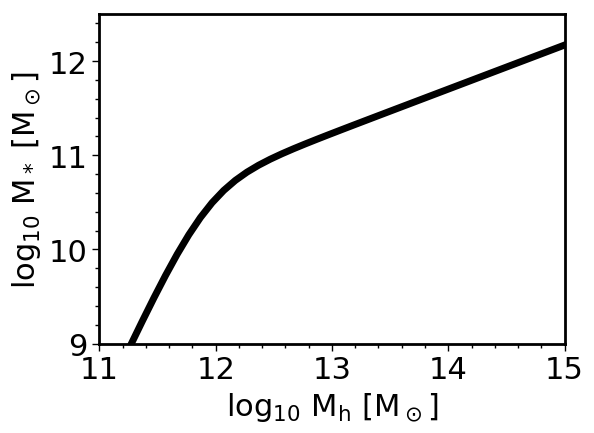

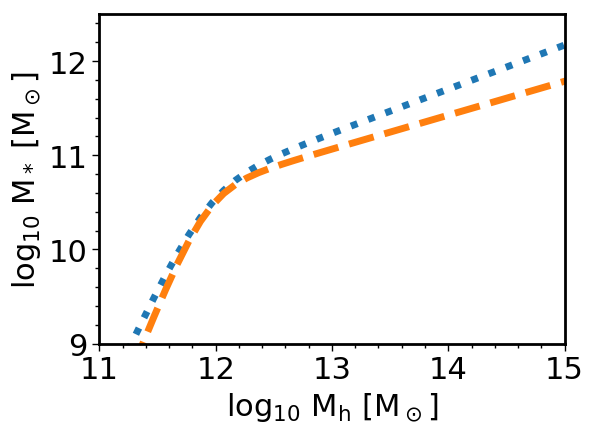

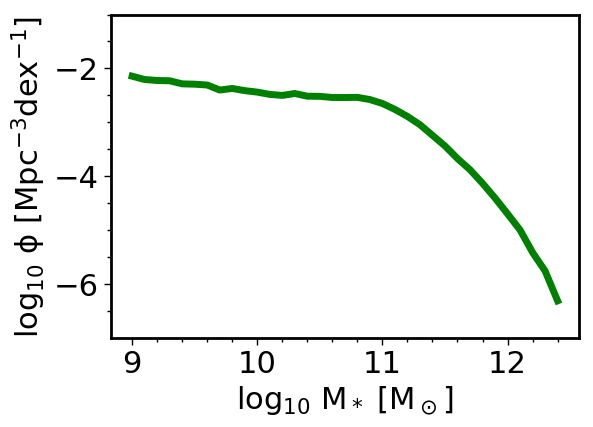

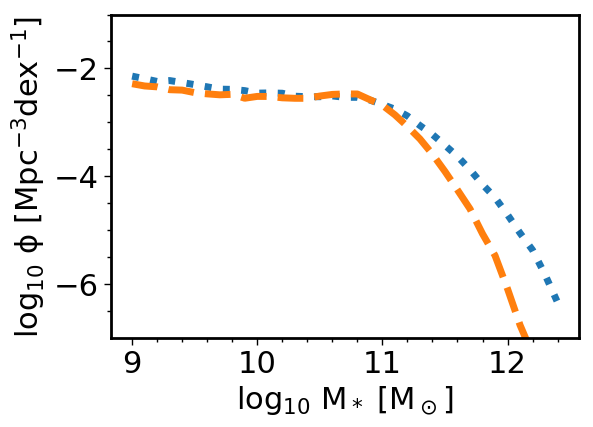

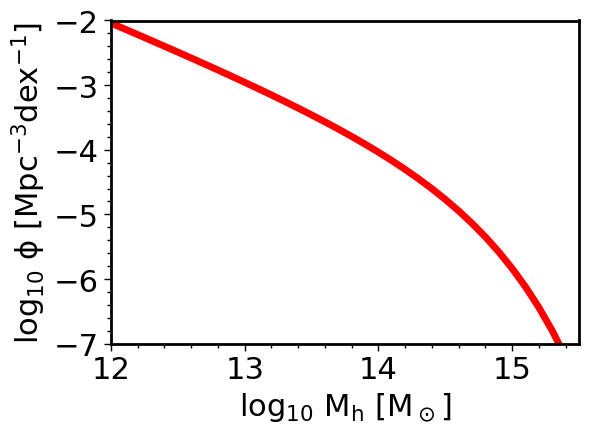

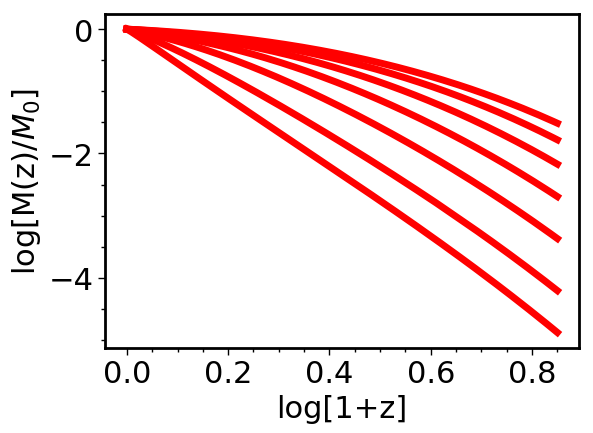

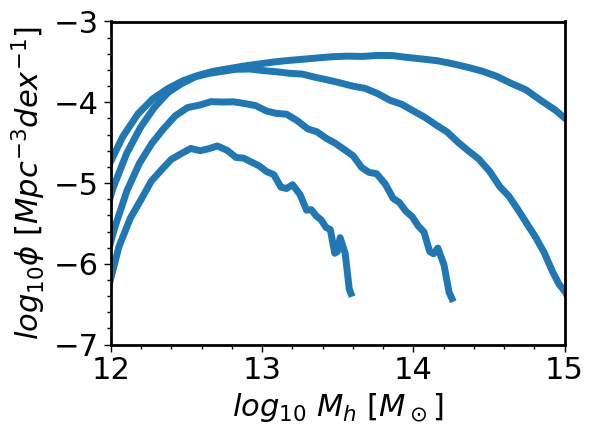

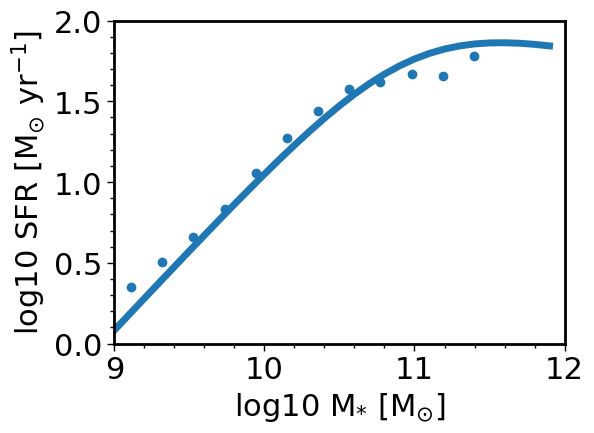

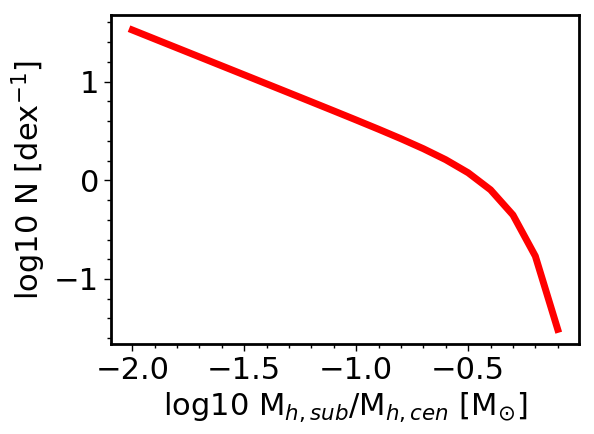

<Figure size 640x480 with 0 Axes>

In [61]:
#set plot paramaters here
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.titlepad'] = 20
plt.rcParams['font.size']=22
plt.rcParams['lines.linewidth']=5

X = np.arange(10, 15, 0.1) #M h-1 #virial


AbnMtch['G19_SE'] = True
plt.plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), "-k")
AbnMtch['G19_SE'] = False
plt.ylim(9, 12.5)
plt.xlim(11, 15)
plt.xlabel("$\mathrm{log_{10}}$ $\mathrm{M_h}$ $\mathrm{[M_\odot]}$")
plt.ylabel("$\mathrm{log_{10}}$ $\mathrm{M_*}$ $\mathrm{[M_\odot]}$")
plt.tight_layout()
plt.savefig(AbsPath+"/Figures/Paper2/SMHM_Cartoon.png")
plt.show()
plt.clf()


AbnMtch['G19_SE'] = True
plt.plot(np.arange(10, 15, 0.1)- np.log10(h),\
         F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), ":C0")
AbnMtch['G19_SE'] = False
AbnMtch['G19_cMod'] = True
plt.plot(np.arange(10, 15, 0.1)- np.log10(h),\
         F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), "--C1")
AbnMtch['G19_cMod'] = False
plt.ylim(9, 12.5)
plt.xlim(11, 15)
plt.xlabel("$\mathrm{log_{10}}$ $\mathrm{M_h}$ $\mathrm{[M_\odot]}$")
plt.ylabel("$\mathrm{log_{10}}$ $\mathrm{M_*}$ $\mathrm{[M_\odot]}$")
plt.tight_layout()
plt.savefig(AbsPath+"/Figures/Paper2/SMHM_diff_Cartoon.png")
plt.show()
plt.clf()





AbnMtch['G19_SE'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins, SMF, "-g")
AbnMtch['G19_SE'] = False
plt.ylim(-7, -1)
plt.xlabel("$\mathrm{log_{10}}$ $\mathrm{M_*}$ $\mathrm{[M_\odot]}$")
plt.ylabel("$\mathrm{log_{10}}$ $\mathrm{\phi}$ $\mathrm{[Mpc^{-3}dex^{-1}]}$")
plt.tight_layout()
plt.savefig(AbsPath+"/Figures/Paper2/SMF_Cartoon.png")
plt.show()
plt.clf()





AbnMtch['G19_SE'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins, SMF, ":C0")
AbnMtch['G19_SE'] = False


AbnMtch['G19_cMod'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins, SMF, "--C1")
AbnMtch['G19_cMod'] = False

plt.ylim(-7, -1)
plt.xlabel("$\mathrm{log_{10}}$ $\mathrm{M_*}$ $\mathrm{[M_\odot]}$")
plt.ylabel("$\mathrm{log_{10}}$ $\mathrm{\phi}$ $\mathrm{[Mpc^{-3}dex^{-1}]}$")
plt.tight_layout()
plt.savefig(AbsPath+"/Figures/Paper2/SMF_diff_Cartoon.png")
plt.show()
plt.clf()



plt.plot(Halo_MR,np.log10(HMF_fun(Halo_MR, 0)), "r")
plt.xlabel("$\mathrm{log_{10}}$ $\mathrm{M_h}$ $\mathrm{[M_\odot]}$")
plt.ylabel("$\mathrm{log_{10}}$ $\mathrm{\phi}$ $\mathrm{[Mpc^{-3}dex^{-1}]}$")
plt.xlim(12, 15.5)
plt.ylim(-7, -2)
plt.tight_layout()
plt.savefig(AbsPath+"/Figures/Paper2/HMF_Cartoon.png")
plt.show()
plt.clf()


AvaHaloMass_wz = np.loadtxt(AbsPath+"/Data/Model/Input/11.517.10.10.6774.dat")      
#Plots the massgrowth of out halos
for i in range(1, len(AvaHaloMass_wz[0])):
    ColorParam = len(AvaHaloMass_wz[0]) - 1
    if (i == 1) or (i == len(AvaHaloMass_wz[0]) -1) or i%10 == 0:
        plt.plot(np.log10(AvaHaloMass_wz[:,0] +1), AvaHaloMass_wz[:,i] - AvaHaloMass_wz[:,i][0], color = "r" )
    #else:
        #plt.plot(np.log10(AvaHaloMass_wz[:,0] +1), AvaHaloMass_wz[:,i] - AvaHaloMass_wz[:,i][0], color = ( (ColorParam-i)/ColorParam, 0, (i-1)/ColorParam ) )
plt.xlabel("log[1+z]")
plt.ylabel("log[M(z)/$M_0$]")
plt.tight_layout()
plt.savefig(AbsPath+"/Figures/Paper2/HaloGrowth_Cartoon.png")
plt.show()
plt.clf()




AvaHaloMass, z, AnalyticalModelFrac_highz, AnalyticalModelNoFrac_highz, SM_Cuts = F.LoadData_Sat_Env_Highz(('1.0', True, True, True, 'G19_DPL', 'G19_SE'))  
SM_Cuts_Plt = [10.5] # use this to pick SM_Cut to plot
Redshift_Bins = np.digitize([0.1,1,2,3], bins = z)
AvaHaloMassBins = AvaHaloMass[:,1:] - AvaHaloMass[:,:-1] 
AvaHaloMassBins = np.concatenate((AvaHaloMassBins, np.array([AvaHaloMassBins[:,-1]]).T), axis = 1)
for j, Cut in enumerate(SM_Cuts_Plt):
    X_SDSS, Y_SDSS = Add_SDSS.NoFracPlot(plt, SM_Cut = Cut)
    plt.clf()
    for i, z_ in enumerate(z):
        if np.any(i == Redshift_Bins):
            Data_ix = np.digitize(Cut, bins = SM_Cuts)-1
            X_Bin = np.digitize(X_SDSS[0], AvaHaloMass[i]- np.log10(h))
            Y_Model = np.divide(AnalyticalModelNoFrac_highz[Data_ix][i], AvaHaloMassBins[i])
            X, Y = F.Gauss_Scatt(AvaHaloMass[i, X_Bin:]- np.log10(h), Y_Model[X_Bin:], Scatt = 0.1)

            plt.plot(X-0.1, np.log10(Y), "-", color =  "C0")
plt.xlabel("$log_{10}$ $M_h$ [$M_\odot$]")
plt.ylabel("$log_{10} \phi$ $[Mpc^{-3} dex^{-1}]$")
plt.xlim(12,15)
plt.ylim(-7,-3)
plt.tight_layout()
plt.savefig(AbsPath+"/Figures/Paper2/ClusterRichness_Cartoon.png")
plt.show()
plt.clf()


L2=np.loadtxt(AbsPath+"/Data/Observational/Leja_SFR/z2.dat", skiprows = 1)
def G19_SFR_DPL(M_out, z = 0.5):
    M_n = np.power(10, 10.65 + 0.33*z - 0.08*(z**2))
    Norm = 0.69 + 0.71*z - 0.088*(z**2)
    Alpha = 1.0 - 0.022*z + 0.009*(z**2)
    Beta = 1.8 - 1.0*z + 0.1*(z**2)
    MperY = 2*(10**Norm)*np.power( np.power(np.divide(10**M_out, M_n), -Alpha) + np.power(np.divide(10**M_out, M_n), Beta), -1)
    return np.log10(MperY)
M = np.arange(7, 12, 0.1)
plt.plot(M, G19_SFR_DPL(M, 2.0), "-", color = "C0")

#Leja
plt.plot(L2[:,0], np.log10(L2[:,1]), "oC0")

plt.ylabel("log10 SFR [M$_{\odot}$ yr$^{-1}$]")
plt.xlabel("log10 M$_{*}$ [M$_{\odot}$]")
plt.xlim(9, 12)
plt.ylim(-0.0, 2)
plt.tight_layout()
plt.savefig(AbsPath+"/Figures/Paper2/SFR_Cartoon.png")
plt.show()
plt.clf()


#Subhalomass function parameters macc/M0
Unevolved = {\
'gamma' : 0.22,\
'alpha' : -0.91,\
'beta' : 6,\
'omega' : 3,\
'a' : 1,\
}

m_M = np.arange(-2, 0, 0.1)
Y = F.dn_dlnX(Unevolved, np.power(10, m_M))

plt.plot(m_M, np.log10(Y), "r")
plt.ylabel("log10 N [dex$^{-1}$]")
plt.xlabel("log10 M$_{h, sub}$/M$_{h, cen}$ [M$_{\odot}$]")
plt.tight_layout()
plt.savefig(AbsPath+"/Figures/Paper2/SHMF_Cartoon.png")
plt.show()
plt.clf()

#set plot paramaters here
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.titlepad'] = 20
plt.rcParams['font.size']=15
plt.rcParams['lines.linewidth']=2

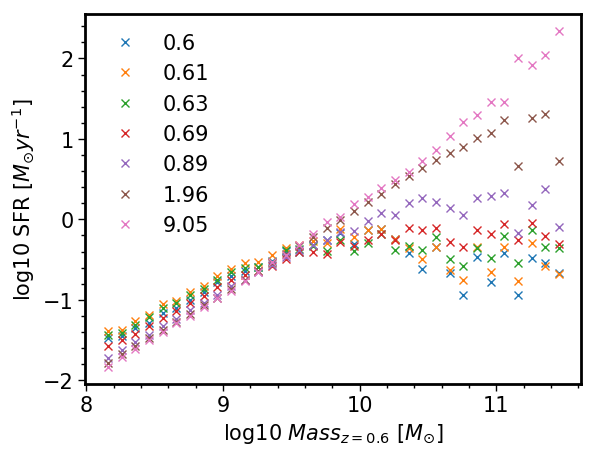

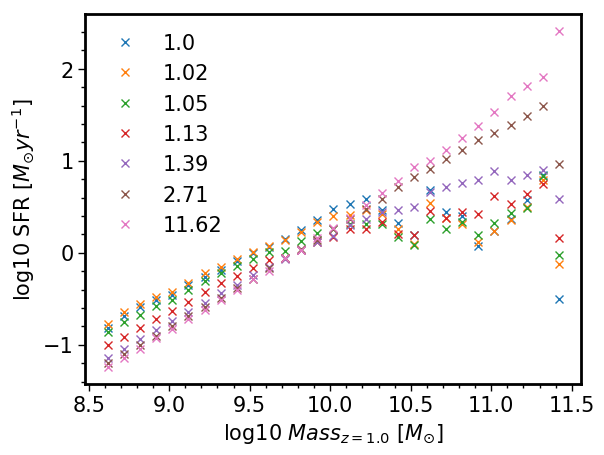

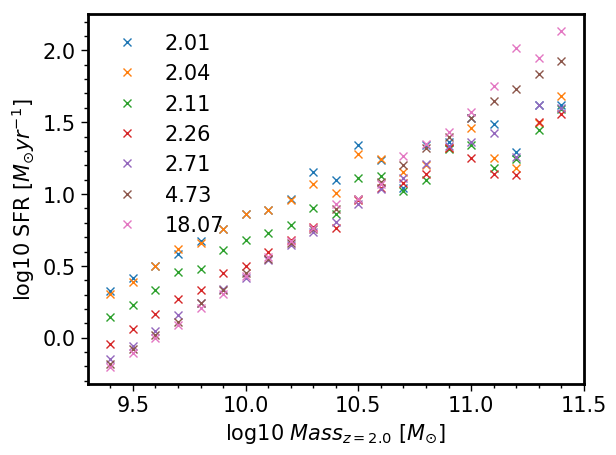

In [66]:
#Open the file from Joel
File = open(AbsPath+"/Data/Observational/Leja_SFR/sfh_stack_pip.pickle", "rb")
#Load the data from pickle, note latin1 required due to python 2 to python 3
Data = pickle.load(File, encoding='latin1')

#Calculate the SFR by multipying the median sSFR by the mass
SFR_06 = Data['0.6']['sfr_med']*np.power(10, np.full((7, np.size(Data['0.6']['mvec'])) , Data['0.6']['mvec']).T)
#Get the redshift of the SFH steps by calculating the total lookback time then convering back to redshift 
z_06 = Cosmo.lookbackTime(Cosmo.lookbackTime(0.6)+np.mean(10**Data['0.6']['agebins']/10**9, axis = 1), inverse = True)
for i, SFR in enumerate(SFR_06.T):
    plt.plot(Data['0.6']['mvec'], np.log10(SFR), "x", label = round(z_06[i], 2))
plt.legend(frameon = False)
plt.xlabel(r"log10 $Mass_{z=0.6}$ [$M_{\odot}$]")
plt.ylabel(r"log10 SFR [$M_{\odot} yr^{-1}$]")
plt.show()

#Calculate the SFR by multipying the median sSFR by the mass
SFR_1 = Data['1.0']['sfr_med']*np.power(10, np.full((7, np.size(Data['1.0']['mvec'])) , Data['1.0']['mvec']).T)
#Get the redshift of the SFH steps by calculating the total lookback time then convering back to redshift 
z_1 = Cosmo.lookbackTime(Cosmo.lookbackTime(1.0)+np.mean(10**Data['1.0']['agebins']/10**9, axis = 1), inverse = True)
for i, SFR in enumerate(SFR_1.T):
    plt.plot(Data['1.0']['mvec'], np.log10(SFR), "x", label = round(z_1[i], 2))
plt.legend(frameon = False)
plt.xlabel(r"log10 $Mass_{z=1.0}$ [$M_{\odot}$]")
plt.ylabel(r"log10 SFR [$M_{\odot} yr^{-1}$]")
plt.show()

#Calculate the SFR by multipying the median sSFR by the mass
SFR_2 = Data['2.0']['sfr_med']*np.power(10, np.full((7, np.size(Data['2.0']['mvec'])) , Data['2.0']['mvec']).T)
#Get the redshift of the SFH steps by calculating the total lookback time then convering back to redshift
z_2 = Cosmo.lookbackTime(Cosmo.lookbackTime(2.0)+np.mean(10**Data['2.0']['agebins']/10**9, axis = 1), inverse = True)
for i, SFR in enumerate(SFR_2.T):
    plt.plot(Data['2.0']['mvec'], np.log10(SFR), "x", label = round(z_2[i], 2))
plt.legend(frameon = False)
plt.xlabel(r"log10 $Mass_{z=2.0}$ [$M_{\odot}$]")
plt.ylabel(r"log10 SFR [$M_{\odot} yr^{-1}$]")
plt.show()

In [72]:
Time = 10**Data['0.6']['agebins']/10**9
Deltas = Time[:,1] - Time[:,0]
MassGrowth = np.log10(SFR_06*(Deltas*10**9))

In [11]:
SMF_Bins

array([ 9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9, 10. ,
       10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11. , 11.1,
       11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. , 12.1, 12.2,
       12.3, 12.4])

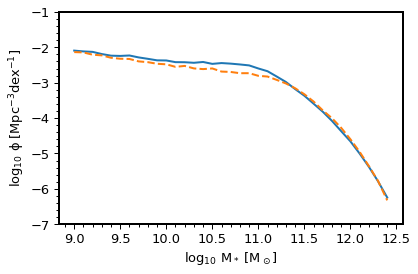

749060142.7918841
584148512.5723629
1.2823111360727677
0.7798419368505373


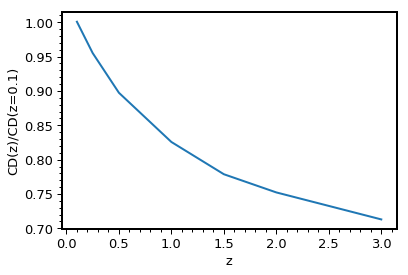

<Figure size 432x288 with 0 Axes>

In [27]:
#Generate and integrate the SMF at 0.1 and 1.5
#Generating
AbnMtch['G19_SE'] = True
SMFpt1 = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = 0.1, N = 1000)[1]
SMF1p5 = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = 1.5, N = 1000)[1]
plt.plot(SMF_Bins, SMFpt1, "-C0")
plt.plot(SMF_Bins, SMF1p5, "--C1")
AbnMtch['G19_SE'] = False
#Plotting
plt.xlabel("$\mathrm{log_{10}}$ $\mathrm{M_*}$ $\mathrm{[M_\odot]}$");plt.ylabel("$\mathrm{log_{10}}$ $\mathrm{\phi}$ $\mathrm{[Mpc^{-3}dex^{-1}]}$")
plt.ylim(-7, -1);plt.tight_layout();plt.show();plt.clf()
#defining functions for quad
def Fpt1(M):
    Bin = np.digitize(np.log10(M), SMF_Bins) - 1
    return np.power(10, SMFpt1[Bin])
def F1p5(M):
    Bin = np.digitize(np.log10(M), SMF_Bins) - 1
    return np.power(10, SMF1p5[Bin])

Ipt1 = integrate.quad(Fpt1, 10**9.5, 10**12.3, limit = 1000)[0]
I1p5 = integrate.quad(F1p5, 10**9.5, 10**12.3, limit = 1000)[0]

print(Ipt1)
print(I1p5)
print(Ipt1/I1p5)
print(I1p5/Ipt1)


#Geralising

def MasterFun(z):
    AbnMtch['G19_SE'] = True
    SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = z, N = 1000)[1]
    AbnMtch['G19_SE'] = False
    def Func(M):
        Bin = np.digitize(np.log10(M), SMF_Bins) - 1
        return np.power(10, SMF[Bin])
    I = integrate.quad(Func, 10**9.5, 10**12.3, limit = 1000)[0]
    return I

z_arr = [0.1, 0.25, 0.5, 1, 1.5, 2, 3]
Ratios = [ MasterFun(i)/Ipt1  for i in z_arr]

plt.plot(z_arr, Ratios)
plt.ylabel(r"CD(z)/CD(z=0.1)")
plt.xlabel(r"z")
plt.savefig(AbsPath+"/Figures/Paper2/CD_z.png")
plt.show()
plt.clf()
    

In [24]:
print(Ratios)

[1.0097014316448105, 0.9611796709034764, 0.9062533989263079, 0.8305264614934875, 0.7867454861497337, 0.7594375500896364, 0.7202910716150653]
